In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transform
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import os

# 1. Data Loading and Preprocessing

We start by loading the dependencies and data, and exploring the dataset to look at its structure. We also print some images to get a hang of it.

In [ ]:
data_dir = '../Pneumonia Detection/chest_xray'


print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['NORMAL', 'PNEUMONIA']


In [7]:
pneumonia_files = os.listdir(data_dir + "/train/PNEUMONIA")
print('No. of training examples for Pneumonia:', len(pneumonia_files))
print(pneumonia_files[:5])

No. of training examples for Pneumonia: 3884
['.DS_Store', 'person1000_bacteria_2931.jpeg', 'person1000_virus_1681.jpeg', 'person1001_bacteria_2932.jpeg', 'person1002_bacteria_2933.jpeg']


In [8]:
normal_files = os.listdir(data_dir + "/train/NORMAL")
print('No. of training examples for Normal:', len(normal_files))
print(normal_files[:5])

No. of training examples for Normal: 1349
['IM-0115-0001.jpeg', 'IM-0117-0001.jpeg', 'IM-0119-0001.jpeg', 'IM-0122-0001.jpeg', 'IM-0125-0001.jpeg']


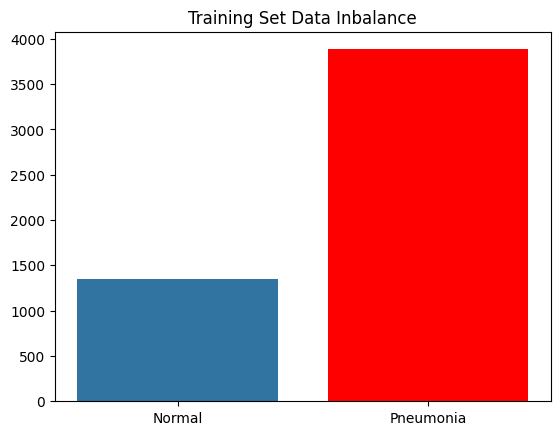

In [9]:
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/train/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/train/PNEUMONIA')])]})


ax = sns.barplot(data=train_samplesize)
ax.bar(train_samplesize.columns[1], train_samplesize['Pneumonia'], color='red')

plt.title('Training Set Data Inbalance')
plt.show()

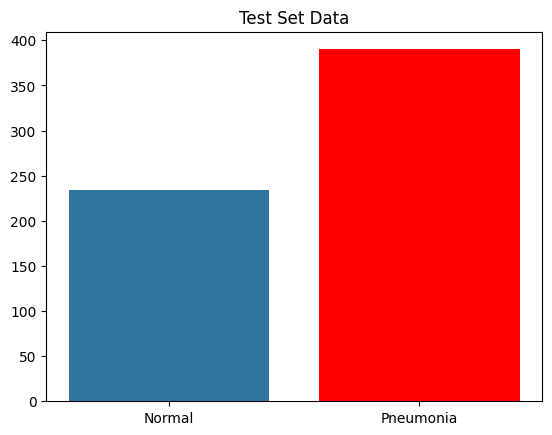

In [10]:
# number of images for each class

test_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/test/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/test/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_dir+'/test/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/test/PNEUMONIA')])]})

ax = sns.barplot(data=test_samplesize)
ax.bar(test_samplesize.columns[1], test_samplesize['Pneumonia'], color='red')

plt.title('Test Set Data')
plt.show()

In [11]:
train_dataset = ImageFolder(data_dir+'/train', 
                      transform=transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(),
                                            transform.RandomRotation(10),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            transform.ToTensor()
                                            #tt.Normalize(mean=[0.485, 0.456, 0.406], 
                                            #std=[0.229, 0.224, 0.225] ,inplace=True)
                                           ]))

test_dataset = ImageFolder(data_dir+'/test', 
                           transform=transform.Compose([transform.Resize(255),
                                                 transform.CenterCrop(224),                                                              
                                                 transform.ToTensor()
                                                 #tt.Normalize(mean=[0.485, 0.456, 0.406], 
                                                 #             std=[0.229, 0.224, 0.225],
                                                 #             inplace=True)
                                                ]))

In [12]:
train_size = round(len(train_dataset)*0.7) # 70%
val_size = len(train_dataset) - train_size # 30%

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(3662, 1570)

In [13]:
batch_size=128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

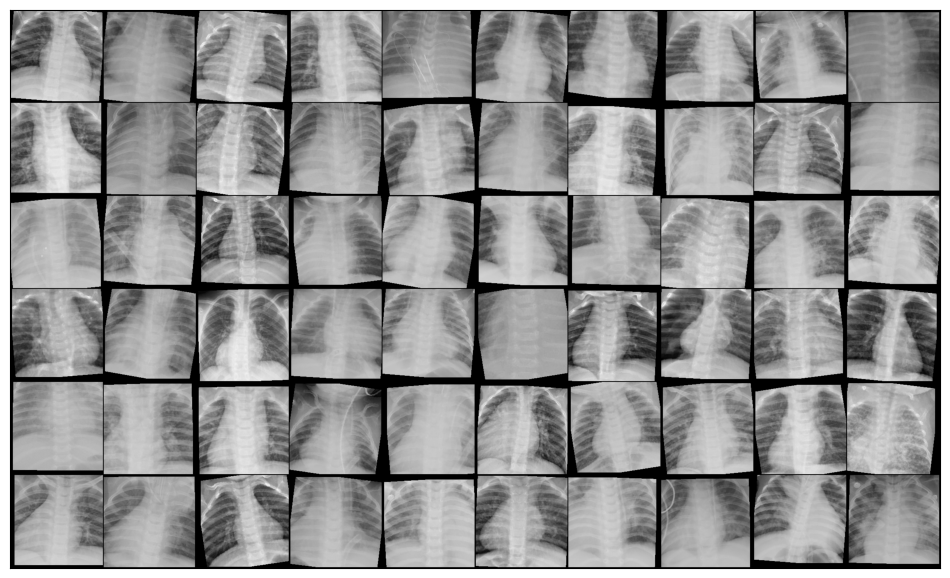

In [14]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        break
        
show_batch(train_dl)

# 2. ResNet model and tests

In [15]:
def train_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.sum(preds == labels).item() / len(preds)

In [16]:
class PneumoniaResNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Freeze training for all layers before classifier
        for param in self.network.fc.parameters():
            param.require_grad = False  
        num_features = self.network.fc.in_features # get number of in features of last layer
        self.network.fc = nn.Linear(num_features, 2) # replace model classifier
    
    def forward(self, xb):
        out=self.network(xb)
        out = F.softmax(out, dim=1)
        return out   

In [13]:
#define number of epochs
n=10

#define weight to reduce inbalance
norm_im,pneum_im = 1349,3884
tot_im=norm_im+pneum_im
weight = torch.FloatTensor([pneum_im/tot_im, norm_im/tot_im]) 

#define dataset
batch_size=128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2,  pin_memory=True)

#define model
model = PneumoniaResNet() ##.cuda() to use GPU

#define loss function
criterion = nn.CrossEntropyLoss(weight=weight)

#define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

#define scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)

#define history
history={}

for epoch in range(n):

    print(f"Epoch n°{epoch+1}")

    #Training step 

    train_accs=[]
    losses = []

    for input, target in train_dl:
        #clear all gradients
        optimizer.zero_grad()

        #feed data into model
        pred = model(input)##.cuda() to use GPU
        
        #calculate loss
        loss = criterion(pred,target)
        losses.append(loss.detach())

        #calculate all gradients
        loss.backward()

        #backforward propagation and update network
        optimizer.step()

        #accuracy
        acc=train_accuracy(pred,target)
        train_accs.append(acc)

    #adjust learning rate
    scheduler.step()

    #print accuracy and loss
    train_acc=np.array(train_accs).sum()/len(train_accs)
    train_loss=torch.stack(losses).mean()

    print(f"Training accuracy : {train_acc}")
    print(f"Training loss : {train_loss}")


    #Validation step
    model.eval()
    val_infos=[]

    for input, target in val_dl:
        pred=model(input)
        loss=criterion(pred,target)
        acc=train_accuracy(pred,target)
        val_info={'val_loss' : loss.detach(), 'val_acc' : acc}
        val_infos.append(val_info)
    
    batch_losses = [x['val_loss'] for x in val_infos]         # get all the batches loss
    val_loss = torch.stack(batch_losses).mean()           # combine losses
    batch_accs = [x['val_acc'] for x in val_infos]            # get all the batches acc
    val_acc = np.array(batch_accs).sum()/len(batch_accs)              # combine accuracies
    
    print(f"Valuation loss : {val_loss.item()}")
    print(f"Valuation accuracy : {val_acc.item()}")

    # save results to dictionary
    to_add = {'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc}
    
    # update performance dictionary
    for key,val in to_add.items():
        if key in history:
            history[key].append(val)
        else:
            history[key] = [val]

C:\Users\yoann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\yoann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch n°1
Training accuracy : 0.9111198607427056
Training loss : 0.39340832829475403
Valuation loss : 0.7713102698326111
Valuation accuracy : 0.7501313025210085
Epoch n°2
Training accuracy : 0.9012903404067197
Training loss : 0.41167986392974854
Valuation loss : 0.40615028142929077
Valuation accuracy : 0.8542542016806722
Epoch n°3
Training accuracy : 0.9561850685234307
Training loss : 0.3599754273891449
Valuation loss : 0.343059241771698
Valuation accuracy : 0.9698660714285714
Epoch n°4
Training accuracy : 0.9540713417329796
Training loss : 0.35394948720932007
Valuation loss : 0.36782529950141907
Valuation accuracy : 0.9179359243697479
Epoch n°5
Training accuracy : 0.9596112400530503
Training loss : 0.34704798460006714
Valuation loss : 0.35441869497299194
Valuation accuracy : 0.9698660714285714
Epoch n°6
Training accuracy : 0.9756990495137047
Training loss : 0.33636531233787537
Valuation loss : 0.3390240967273712
Valuation accuracy : 0.9712447478991597
Epoch n°7
Training accuracy : 0.9

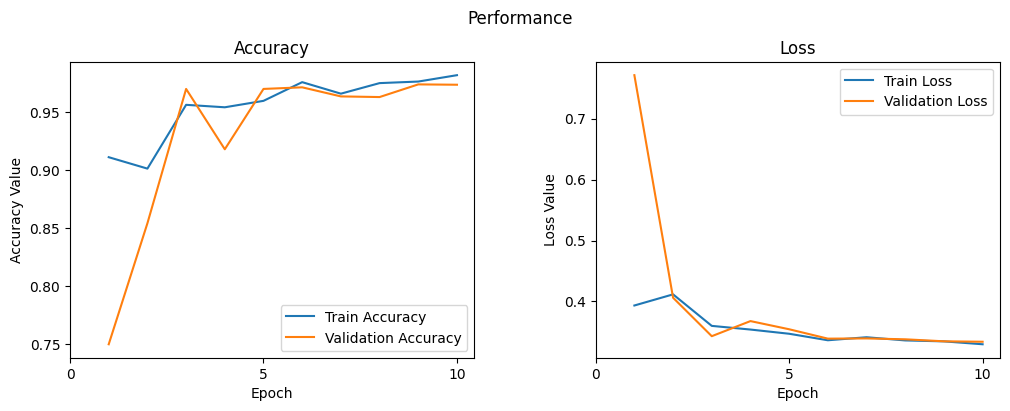

In [14]:
# Plot Accuracy and Loss 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,n+1))
ax1.plot(epoch_list, history['train_acc'], label='Train Accuracy')
ax1.plot(epoch_list, history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, n+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history['train_loss'], label='Train Loss')
ax2.plot(epoch_list, history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, n+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [21]:
test_dataset = ImageFolder(data_dir+'/test', 
                           transform=transform.Compose([transform.Resize(255),
                                                 transform.CenterCrop(224),                                                              
                                                 transform.ToTensor()
                                                 #tt.Normalize(mean=[0.485, 0.456, 0.406], 
                                                 #             std=[0.229, 0.224, 0.225],
                                                 #             inplace=True)
                                                ]))

In [22]:
test_dl = DataLoader(test_dataset, batch_size=512)

In [23]:
preds=[]
targets=[]
#switch to evaluating mode
model.eval()
with torch.no_grad():
    for input,target in test_dl:
        #feed data into model
        pred = model(input)
        print(pred)
        #Convert probabilities to binary predictions (0 or 1)
        pred_binary = torch.argmax(pred, dim=1)
        #save target and prediction
        preds.append(pred_binary.numpy().flatten())
        targets.append(target.numpy().flatten())

tensor([[9.9997e-01, 3.1623e-05],
        [1.0000e+00, 1.1840e-07],
        [1.0000e+00, 3.8512e-07],
        ...,
        [3.3176e-12, 1.0000e+00],
        [6.6685e-11, 1.0000e+00],
        [6.8121e-05, 9.9993e-01]])
tensor([[2.7009e-12, 1.0000e+00],
        [2.2408e-12, 1.0000e+00],
        [7.5738e-12, 1.0000e+00],
        [8.0634e-12, 1.0000e+00],
        [2.3881e-13, 1.0000e+00],
        [5.1185e-11, 1.0000e+00],
        [8.0130e-14, 1.0000e+00],
        [2.7319e-01, 7.2681e-01],
        [4.6836e-12, 1.0000e+00],
        [6.2079e-09, 1.0000e+00],
        [6.9657e-12, 1.0000e+00],
        [8.8870e-14, 1.0000e+00],
        [7.1165e-07, 1.0000e+00],
        [8.2299e-02, 9.1770e-01],
        [3.4324e-06, 1.0000e+00],
        [1.9464e-04, 9.9981e-01],
        [2.2715e-14, 1.0000e+00],
        [7.2914e-04, 9.9927e-01],
        [1.0587e-04, 9.9989e-01],
        [3.8539e-12, 1.0000e+00],
        [3.0084e-13, 1.0000e+00],
        [2.8009e-12, 1.0000e+00],
        [1.9129e-15, 1.0000e+00],


In [24]:
#calculate accuracy
def test_accuracy(output, target):
    output,target=torch.tensor(np.array(output)),torch.tensor(np.array(target))
    # Appliquer un seuil de décision de 0.5
    predicted = (output >= 0.5).float()
    # Calculer le nombre de prédictions correctes
    correct = (predicted == target).sum().item()
    # Calculer l'exactitude
    accuracy = correct / target.size(1)
    return accuracy

<Figure size 640x480 with 0 Axes>

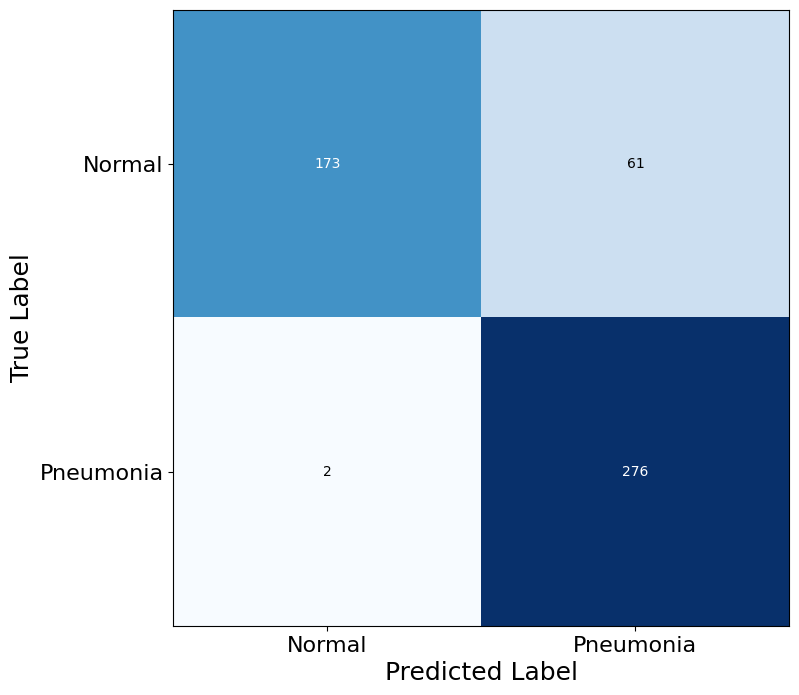

In [25]:
# Plot confusion matrix
plt.figure()
cm=confusion_matrix(targets[0],preds[0])
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [29]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy=(tp+tn)/(tn+fp+fn+tp)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Accuracy of the model is 0.88
Recall of the model is 0.99
Precision of the model is 0.82
F1 Score of the model is 0.90


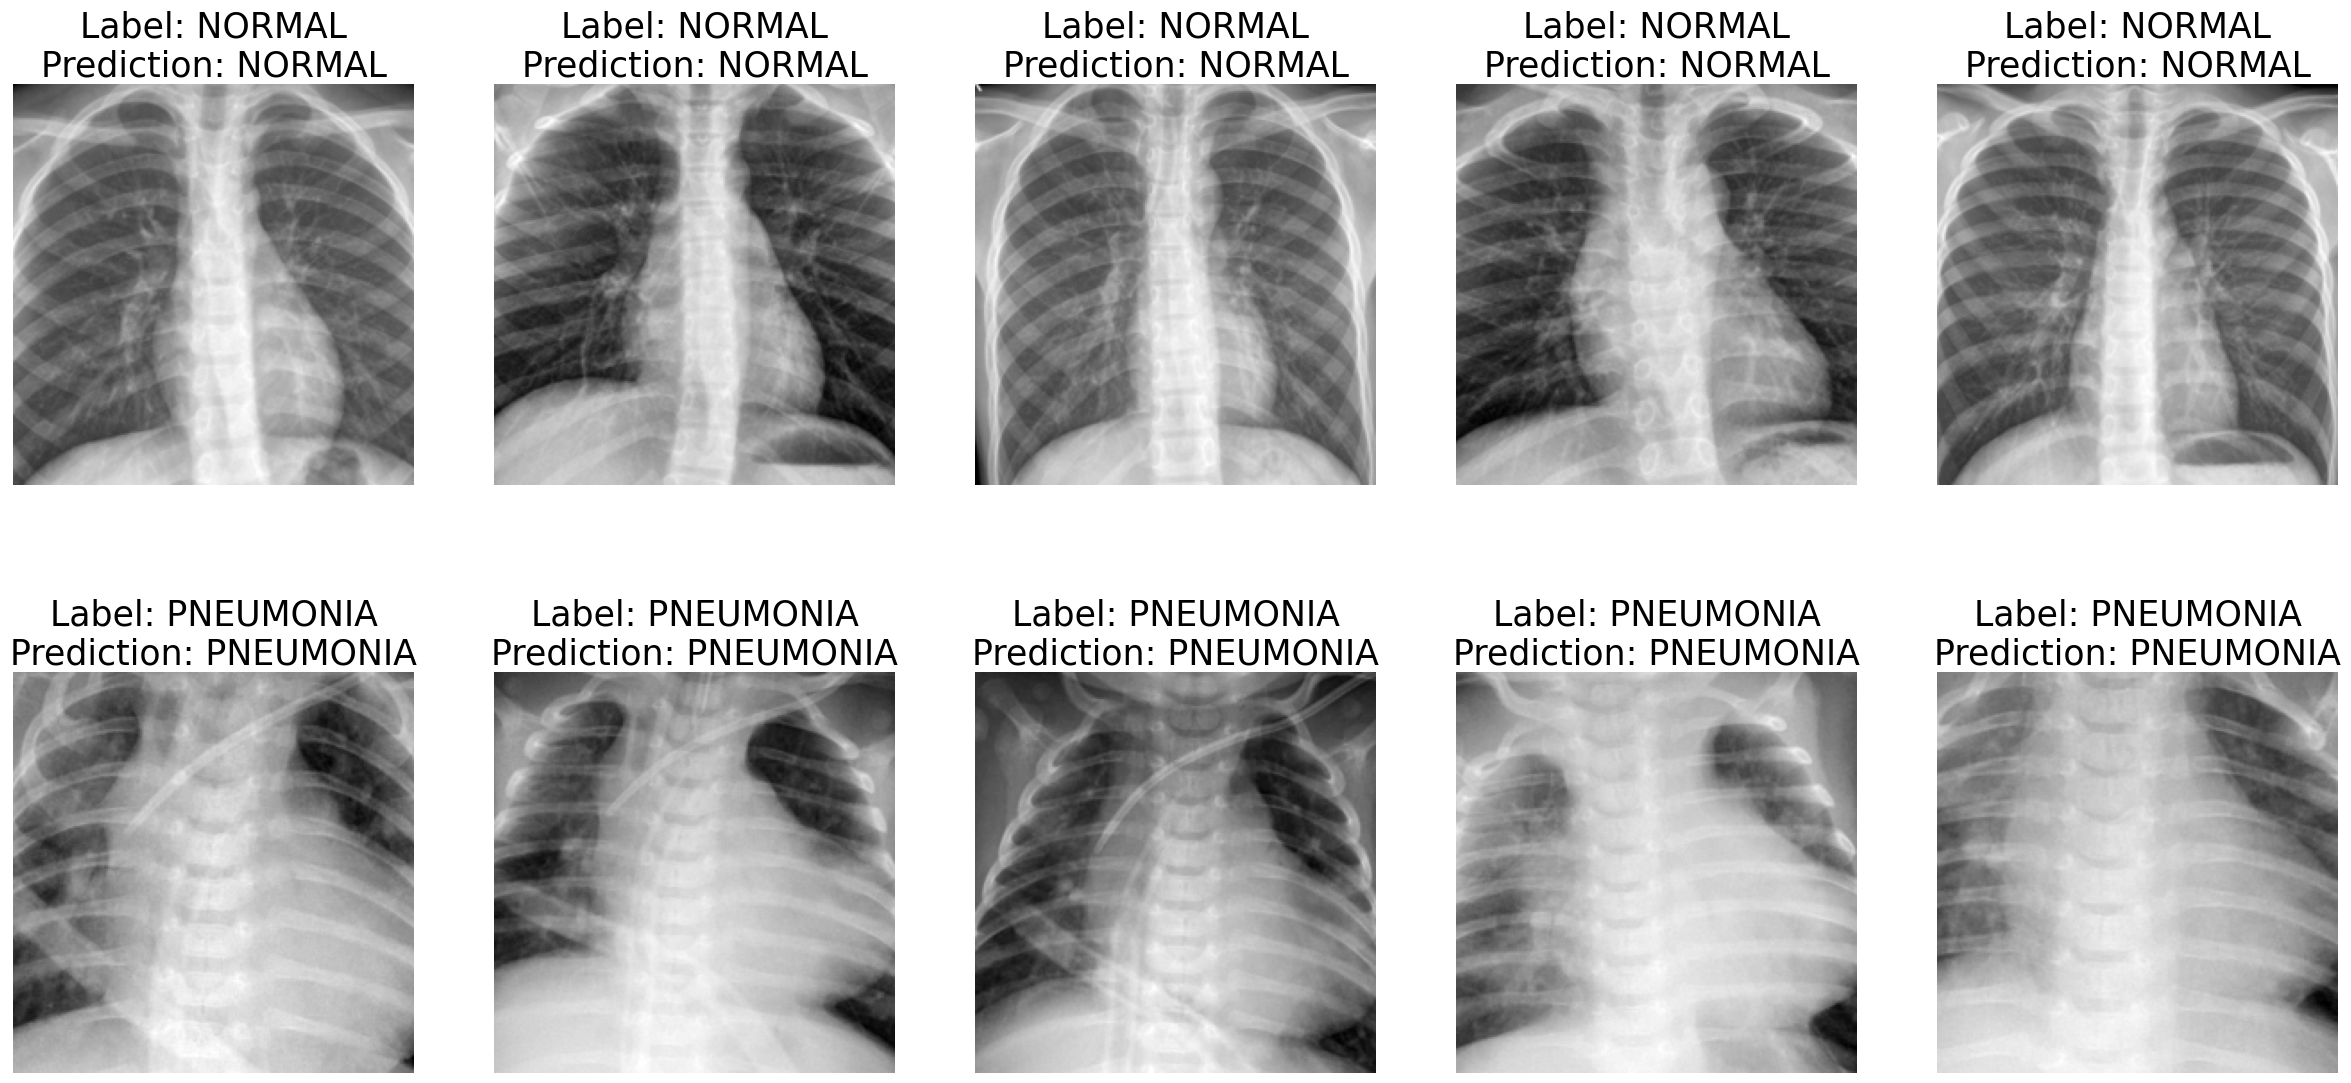

In [27]:
# select 5 normal and 5 pneumonia images indices
idxs = torch.tensor(np.append(np.arange(start=0, stop=5, step=1), 
                             np.arange(start=300, stop=305, step=1))) 

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,14))

for c,i in enumerate(idxs):
    img_tensor, label = test_dataset[i]
    ax[c//5][c%5].imshow(img_tensor[0,:,:], cmap='gray')
    ax[c//5][c%5].set_title('Label: {}\nPrediction: {}'
                            .format(test_dataset.classes[label], 
                                    test_dataset.classes[preds[0][i]]),
                            fontsize=25)
    ax[c//5][c%5].axis('off')
    

In [ ]:
# Save Model
bestmodel = {'model': PneumoniaResNet(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(bestmodel, 'PneumoniaResnet.pth')

In [17]:
from torchvision.models.convnext import CNBlockConfig

class PneumoniaConvNeXt(nn.Module):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.convnext_base(weights='DEFAULT')
        
        # Geler l'entraînement de toutes les couches avant le classifieur
        for param in self.network.parameters():
            param.requires_grad = False

        # Obtenir la dernière couche du classifieur
        modules = list(self.network.modules())
        last_layer = None
        for module in reversed(modules):
            if isinstance(module, nn.Linear):
                last_layer = module
                break

        # Vérifier si une dernière couche linéaire a été trouvée
        if last_layer is not None:
            # Obtenir le nombre de fonctionnalités en entrée de la dernière couche
            num_features = last_layer.in_features

            # Remplacer la dernière couche par une nouvelle couche linéaire avec deux sorties
            self.network.classifier[2] = nn.Linear(num_features, 2)
    
    def forward(self, xb):
        out=self.network(xb)
        out = F.softmax(out, dim=1)
        return out   

In [26]:
help(torch.optim.lr_scheduler.CosineAnnealingLR)

Help on class CosineAnnealingLR in module torch.optim.lr_scheduler:

class CosineAnnealingLR(LRScheduler)
 |  CosineAnnealingLR(optimizer, T_max, eta_min=0, last_epoch=-1, verbose='deprecated')
 |  
 |  Set the learning rate of each parameter group using a cosine annealing
 |  schedule, where :math:`\eta_{max}` is set to the initial lr and
 |  :math:`T_{cur}` is the number of epochs since the last restart in SGDR:
 |  
 |  .. math::
 |      \begin{aligned}
 |          \eta_t & = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})\left(1
 |          + \cos\left(\frac{T_{cur}}{T_{max}}\pi\right)\right),
 |          & T_{cur} \neq (2k+1)T_{max}; \\
 |          \eta_{t+1} & = \eta_{t} + \frac{1}{2}(\eta_{max} - \eta_{min})
 |          \left(1 - \cos\left(\frac{1}{T_{max}}\pi\right)\right),
 |          & T_{cur} = (2k+1)T_{max}.
 |      \end{aligned}
 |  
 |  When last_epoch=-1, sets initial lr as lr. Notice that because the schedule
 |  is defined recursively, the learning rate can be simult

In [29]:
#define number of epochs
n=10

#define weight to reduce inbalance
norm_im,pneum_im = 1349,3884
tot_im=norm_im+pneum_im
weight = torch.FloatTensor([pneum_im/tot_im, norm_im/tot_im]) 

#define dataset
batch_size=128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2,  pin_memory=True)

#define model
model = PneumoniaConvNeXt() ##.cuda() to use GPU

#define loss function
criterion = nn.CrossEntropyLoss(weight=weight)

#define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0004)

#define scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)

#define history
history={}

for epoch in range(n):

    print(f"Epoch n°{epoch+1}")

    #Training step 

    train_accs=[]
    losses = []

    for input, target in train_dl:
        #clear all gradients
        optimizer.zero_grad()

        #feed data into model
        pred = model(input)##.cuda() to use GPU
        
        #calculate loss
        loss = criterion(pred,target)
        losses.append(loss.detach())

        #calculate all gradients
        loss.backward()

        #backforward propagation and update network
        optimizer.step()

        #accuracy
        acc=train_accuracy(pred,target)
        train_accs.append(acc)

    #adjust learning rate
    scheduler.step()

    #print accuracy and loss
    train_acc=np.array(train_accs).sum()/len(train_accs)
    train_loss=torch.stack(losses).mean()

    print(f"Training accuracy : {train_acc}")
    print(f"Training loss : {train_loss}")


    #Validation step
    model.eval()
    val_infos=[]

    for input, target in val_dl:
        pred=model(input)
        loss=criterion(pred,target)
        acc=train_accuracy(pred,target)
        val_info={'val_loss' : loss.detach(), 'val_acc' : acc}
        val_infos.append(val_info)
    
    batch_losses = [x['val_loss'] for x in val_infos]         # get all the batches loss
    val_loss = torch.stack(batch_losses).mean()           # combine losses
    batch_accs = [x['val_acc'] for x in val_infos]            # get all the batches acc
    val_acc = np.array(batch_accs).sum()/len(batch_accs)              # combine accuracies
    
    print(f"Valuation accuracy : {val_acc.item()}")
    print(f"Valuation loss : {val_loss.item()}")

    # save results to dictionary
    to_add = {'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc}
    
    # update performance dictionary
    for key,val in to_add.items():
        if key in history:
            history[key].append(val)
        else:
            history[key] = [val]

Epoch n°1
Training accuracy : 0.6560842175066313
Training loss : 0.634440541267395
Valuation accuracy : 0.8712907037815125
Valuation loss : 0.5584392547607422
Epoch n°2
Training accuracy : 0.8967658598585322
Training loss : 0.5116910338401794
Valuation accuracy : 0.912092962184874
Valuation loss : 0.4890393614768982
Epoch n°3
Training accuracy : 0.91596899867374
Training loss : 0.46670812368392944
Valuation accuracy : 0.8944655987394958
Valuation loss : 0.46286576986312866
Epoch n°4
Training accuracy : 0.9279191534040672
Training loss : 0.44392114877700806
Valuation accuracy : 0.9103860294117647
Valuation loss : 0.4469475746154785
Epoch n°5
Training accuracy : 0.9316147214854111
Training loss : 0.42926347255706787
Valuation accuracy : 0.9209887079831933
Valuation loss : 0.43480974435806274
Epoch n°6
Training accuracy : 0.9303644451812555
Training loss : 0.42187362909317017
Valuation accuracy : 0.9248949579831933
Valuation loss : 0.43244627118110657
Epoch n°7
Training accuracy : 0.92767

In [30]:
test_dataset = ImageFolder(data_dir+'/test', 
                           transform=transform.Compose([transform.Resize(255),
                                                 transform.CenterCrop(224),                                                              
                                                 transform.ToTensor()
                                                 #tt.Normalize(mean=[0.485, 0.456, 0.406], 
                                                 #             std=[0.229, 0.224, 0.225],
                                                 #             inplace=True)
                                                ]))
test_dl = DataLoader(test_dataset, batch_size=512)

In [31]:
preds=[]
targets=[]
#switch to evaluating mode
model.eval()
with torch.no_grad():
    for input,target in test_dl:
        #feed data into model
        pred = model(input)
        print(pred)
        #Convert probabilities to binary predictions (0 or 1)
        pred_binary = torch.argmax(pred, dim=1)
        #save target and prediction
        preds.append(pred_binary.numpy().flatten())
        targets.append(target.numpy().flatten())

tensor([[0.9025, 0.0975],
        [0.9231, 0.0769],
        [0.9447, 0.0553],
        ...,
        [0.0064, 0.9936],
        [0.1543, 0.8457],
        [0.4234, 0.5766]])
tensor([[0.1714, 0.8286],
        [0.1847, 0.8153],
        [0.2356, 0.7644],
        [0.0390, 0.9610],
        [0.1024, 0.8976],
        [0.3987, 0.6013],
        [0.1295, 0.8705],
        [0.6682, 0.3318],
        [0.1959, 0.8041],
        [0.1284, 0.8716],
        [0.0443, 0.9557],
        [0.0352, 0.9648],
        [0.1570, 0.8430],
        [0.4579, 0.5421],
        [0.1729, 0.8271],
        [0.4090, 0.5910],
        [0.0831, 0.9169],
        [0.1869, 0.8131],
        [0.6525, 0.3475],
        [0.0130, 0.9870],
        [0.0541, 0.9459],
        [0.0439, 0.9561],
        [0.3931, 0.6069],
        [0.1443, 0.8557],
        [0.4153, 0.5847],
        [0.0494, 0.9506],
        [0.0205, 0.9795],
        [0.1989, 0.8011],
        [0.0012, 0.9988],
        [0.2969, 0.7031],
        [0.0654, 0.9346],
        [0.1112, 0.8888]

<Figure size 640x480 with 0 Axes>

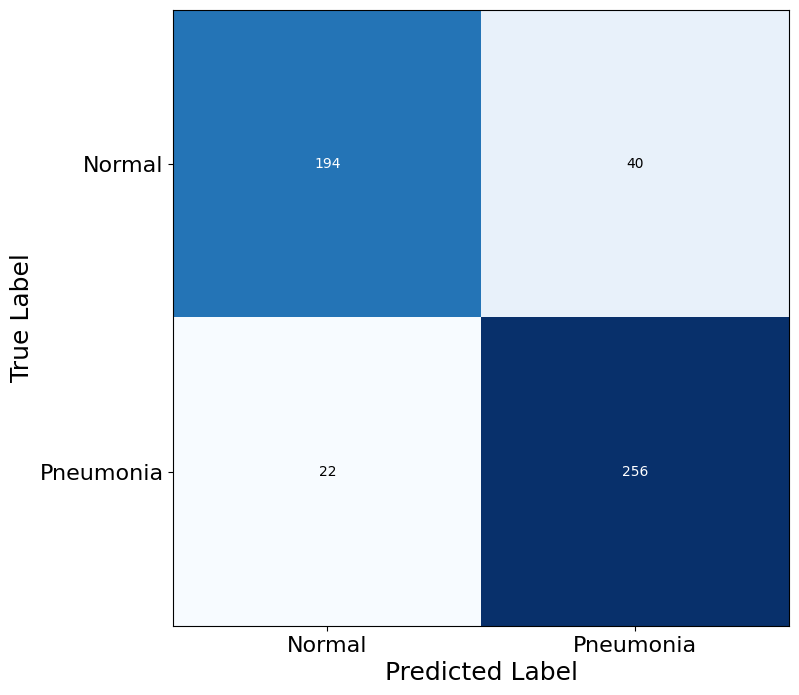

In [32]:
# Plot confusion matrix
plt.figure()
cm=confusion_matrix(targets[0],preds[0])
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [33]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy=(tp+tn)/(tn+fp+fn+tp)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Accuracy of the model is 0.88
Recall of the model is 0.92
Precision of the model is 0.86
F1 Score of the model is 0.89


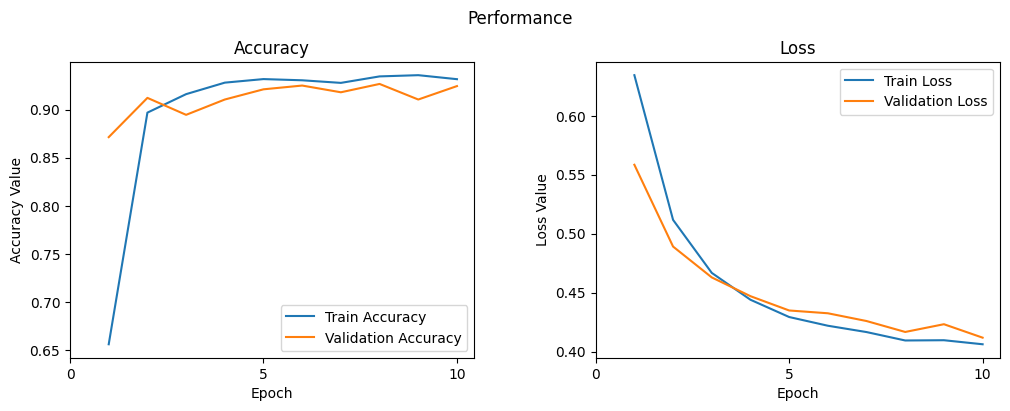

In [34]:
# Plot Accuracy and Loss 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,n+1))
ax1.plot(epoch_list, history['train_acc'], label='Train Accuracy')
ax1.plot(epoch_list, history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, n+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history['train_loss'], label='Train Loss')
ax2.plot(epoch_list, history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, n+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [28]:
# Save Model
bestmodel = {'model': PneumoniaConvNeXt(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(bestmodel, 'PneumoniaConvNeXt.pth')